# Laborator XAI

**Student:** PEREBINOS DANIEL <br>
**Obiectiv:** Utilizarea tehnicilor XAI (LIME, SHAP, Coeficienți) pentru a demonstra nu doar *ce* decid modelele.

Vom compara 3 arhitecturi antrenate în două scenarii:
1.  **Scenario A (Clean):** Date echilibrate și corecte.
2.  **Scenario B (Biased):** Date din care am eliminat intenționat 80% din femeile care părăsesc banca (simulând un bias istoric de colectare).

**Tehnici utilizate:**
* **Feature Importance (Logistic Regression):** Interpretare directă a ponderilor.
* **SHAP (Random Forest):** Interpretare globală non-liniară.
* **LIME (Deep Learning):** Interpretare locală (studiu de caz pe un singur client).

In [13]:
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="talk")

In [14]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

## 1. Crearea Universurilor Paralele: Clean vs. Biased
Pentru a compara explicațiile, avem nevoie de două seturi de date de antrenament diferite, dar de un singur set de testare (realitatea obiectivă).

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Încărcare și Preprocesare Generală
df = pd.read_csv('data/Churn_Modelling.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Encoding
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender']) # 0=Female, 1=Male
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# 1. Dataset CLEAN (Echilibrat prin Undersampling)
churn_df = df[df['Exited'] == 1]
non_churn_df = df[df['Exited'] == 0].sample(n=len(churn_df), random_state=42)
df_clean = pd.concat([churn_df, non_churn_df]).sample(frac=1, random_state=42)

# 2. Dataset BIASED (Eliminăm 80% din Femeile cu Churn din setul Clean)
mask_bias = (df_clean['Gender'] == 0) & (df_clean['Exited'] == 1)
indices_to_drop = df_clean[mask_bias].sample(frac=0.8, random_state=42).index
df_biased = df_clean.drop(indices_to_drop)
df_biased.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
8448,508,1,49,1,93817.41,2,1,1,132468.76,1,False,False
9726,773,1,43,7,138150.57,1,1,1,177357.16,0,False,True
2098,601,0,43,2,0.00,1,1,0,49713.87,1,False,False
6379,679,1,37,7,74260.03,1,1,0,194617.98,0,False,False
1951,604,1,53,8,144453.75,1,1,0,190998.96,1,False,False


In [33]:
# Split și Scalare
X_clean = df_clean.drop('Exited', axis=1)
y_clean = df_clean['Exited']
X_biased = df_biased.drop('Exited', axis=1)
y_biased = df_biased['Exited']

# Folosim un test set comun (extras din original pentru a fi corect)
X_tr_c, X_test, y_tr_c, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Scalare
scaler = StandardScaler()
X_tr_c_sc = scaler.fit_transform(X_tr_c)
X_tr_b_sc = scaler.fit_transform(X_biased)
X_test_sc = scaler.transform(X_test)

feature_names = X_clean.columns.tolist()

print(f"Training Clean Shape: {X_tr_c.shape}")
print(f"Training Biased Shape: {X_biased.shape} (Mult mai puține femei cu churn)")

Training Clean Shape: (3259, 11)
Training Biased Shape: (3163, 11) (Mult mai puține femei cu churn)


## 2. Antrenarea Modelor (The "Brains")
Antrenăm perechi de modele.
* `_c` = Clean Model
* `_b` = Biased Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- 1. Logistic Regression ---
lr_c = LogisticRegression(random_state=42).fit(X_tr_c_sc, y_tr_c)
lr_b = LogisticRegression(random_state=42).fit(X_tr_b_sc, y_biased)

# --- 2. Random Forest ---
rf_c = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr_c, y_tr_c)
rf_b = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_biased, y_biased)

# --- 3. Deep Learning ---
def get_dl_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_tr_c.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dl_c = get_dl_model()
dl_c.fit(X_tr_c_sc, y_tr_c, epochs=30, verbose=0)

dl_b = get_dl_model()
dl_b.fit(X_tr_b_sc, y_biased, epochs=30, verbose=0)

print("Toate cele 6 modele au fost antrenate.")

Toate cele 6 modele au fost antrenate.


## EXPERIMENTUL 1: Regresia Logistică și "Dispariția" Variabilei Gen
La modelele liniare, coeficienții ne spun direct cât de importantă este o trăsătură.
* Coeficient negativ mare = Scade riscul de Churn.
* Coeficient pozitiv mare = Crește riscul de Churn.
* Coeficient zero = Irelevant.

**Ipoteza:** În modelul Clean, `Gender` (unde Femeie=0, Bărbat=1) ar trebui să fie important. În modelul Biased, `Gender` își va pierde puterea sau își va schimba sensul.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Definim tipurile de regularizare, inclusiv "Fără Regularizare"
reg_models = {
    'No Regularization': LogisticRegression(penalty=None, solver='lbfgs', random_state=42),
    'L1 (Lasso)': LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42),
    'L2 (Ridge)': LogisticRegression(penalty='l2', solver='lbfgs', C=0.5, random_state=42),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5, random_state=42)
}

coef_data = []

# Iterăm prin fiecare tip de regularizare
for name, model in reg_models.items():
    print(f"Antrenăm {name}...")

    # 1. Antrenare pe CLEAN
    try:
        model.fit(X_tr_c_sc, y_tr_c)
        # Salvăm coeficienții
        for feat, coef in zip(feature_names, model.coef_[0]):
            coef_data.append({
                'Feature': feat,
                'Coef': coef,
                'Model': 'Clean',
                'Regularization': name
            })
    except Exception as e:
        print(f"Eroare la {name} Clean: {e}")

    # 2. Antrenare pe BIASED
    try:
        model.fit(X_tr_b_sc, y_biased)
        # Salvăm coeficienții
        for feat, coef in zip(feature_names, model.coef_[0]):
            coef_data.append({
                'Feature': feat,
                'Coef': coef,
                'Model': 'Biased',
                'Regularization': name
            })
    except Exception as e:
        print(f"Eroare la {name} Biased: {e}")

# Creăm DataFrame-ul pentru plotare
df_coefs = pd.DataFrame(coef_data)

Antrenăm No Regularization...
Antrenăm L1 (Lasso)...
Antrenăm L2 (Ridge)...
Antrenăm ElasticNet...


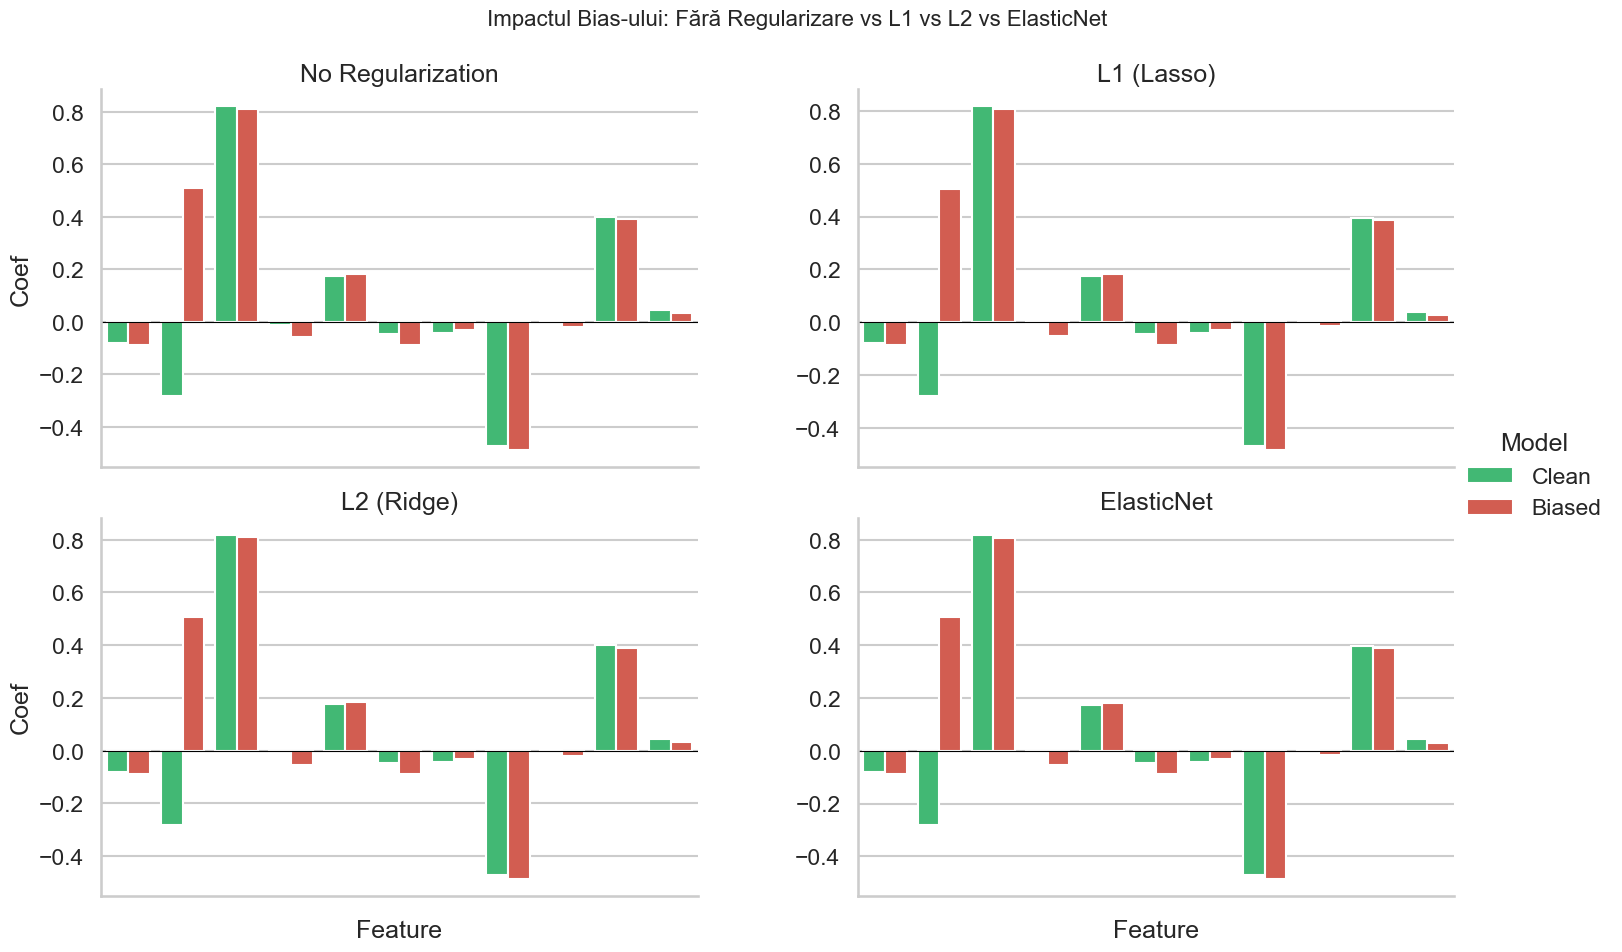

In [34]:
g = sns.catplot(
    data=df_coefs,
    x='Feature',
    y='Coef',
    hue='Model',
    col='Regularization',
    col_wrap=2,
    kind='bar',
    palette=['#2ecc71', '#e74c3c'],
    height=5,
    aspect=1.5,
    sharey=False
)

g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Impactul Bias-ului: Fără Regularizare vs L1 vs L2 vs ElasticNet', fontsize=16)

for ax in g.axes.flat:
    ax.axhline(0, color='black', linewidth=0.8)

plt.show()

**Interpretare Rezultate: Impactul Bias-ului asupra Coeficienților**


**1. „Prăbușirea” variabilei _Gender_**
> Acesta este efectul direct al bias-ului introdus:

- **Modelul Clean _(Verde)_**
  Coeficientul pentru *Gender* este **puternic negativ**.
  Aceasta reflectă realitatea statistică corectă:
  femeile (`0`) au un risc de churn mai mare, deci a fi bărbat (`1`) **scade riscul**.

- **Modelul Biasat _(Roșu)_**
  Coeficientul pentru *Gender* a devenit **aproape zero** (sau chiar pozitiv).

> **Concluzie:**
> Prin eliminarea femeilor care au plecat, modelul a devenit *„orb”* la acest factor.
> A învățat greșit că genul nu contează în predicția plecării.


**2. Ineficiența Regularizării**
> Graficele arată identic pentru **L1**, **L2** și **ElasticNet**.

Faptul că diferențele sunt minime demonstrează că algoritmul **nu poate corecta calitatea proastă a datelor**.
Indiferent cât de sofisticată este matematica (_Lasso_ sau _Ridge_),
dacă datele de intrare ignoră un grup demografic,
modelul îl va ignora și el — **Garbage In, Garbage Out**.


**3. Stabilitatea celorlalți factori**
> Variabile puternice precum **Age (Vârsta)** au rămas constante —
> barele verzi și roșii sunt egale.

Acest lucru confirmă că bias-ul nostru a fost **izolat strict pe Gen**,
dar modelul continuă să funcționeze corect pentru alți factori.


## EXPERIMENTUL 2: Random Forest și SHAP (Global Importance)
SHAP ne arată "ierarhia" factorilor de decizie. Vom vedea cum se schimbă prioritățile modelului.

In [35]:
import shap

# Calculăm SHAP values
explainer_c = shap.TreeExplainer(rf_c)
shap_values_c = explainer_c.shap_values(X_test)

explainer_b = shap.TreeExplainer(rf_b)
shap_values_b = explainer_b.shap_values(X_test)

def get_positive_class_shap(shap_vals):
    if isinstance(shap_vals, list):
        return shap_vals[1]
    elif len(np.array(shap_vals).shape) == 3:
        return shap_vals[:, :, 1]
    else:
        return shap_vals

vals_c = get_positive_class_shap(shap_values_c)
vals_b = get_positive_class_shap(shap_values_b)

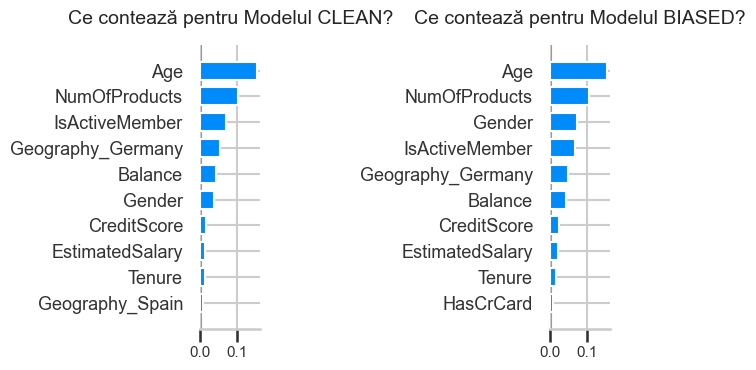

In [42]:
import shap
import matplotlib.pyplot as plt

# Figură principală
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Subgrafic 1 — CLEAN
plt.sca(axes[0])
shap.summary_plot(vals_c, X_test, plot_type="bar", show=False, max_display=10)
axes[0].set_title("Ce contează pentru Modelul CLEAN?", fontsize=14, pad=15)

# Subgrafic 2 — BIASED
plt.sca(axes[1])
shap.summary_plot(vals_b, X_test, plot_type="bar", show=False, max_display=10)
axes[1].set_title("Ce contează pentru Modelul BIASED?", fontsize=14, pad=15)

# 🔧 Eliminăm eticheta de pe axa X (textul lung de jos)
for ax in axes:
    ax.set_xlabel("")

plt.tight_layout(pad=4.0)
plt.show()


**Interpretare Experiment 2: Paradoxul Creșterii Importanței (SHAP)**

**Observație**
Contrar intuiției inițiale, în **modelul Biased** (dreapta), caracteristica **Gender** a devenit mai importantă — a urcat de pe **locul 6** pe **locul 3** — comparativ cu **modelul Clean** (stânga).

**Explicația Fenomenului**
Acesta este un exemplu clasic de **Corelație Falsă (_Spurious Correlation_)** indusă de bias:

- **Ce am făcut:**
  Am eliminat majoritatea femeilor care au făcut `Churn (Exited=1)`.

- **Ce a văzut modelul:**
  În setul de date rămas, aproape toate exemplele cu `Gender=Female` au eticheta `Exited=0 (Stay)`.

- **Ce a învățat modelul:**
  A dedus o regulă „perfectă” — dar greșită în realitate:
  > „Dacă clientul este femeie, sigur va rămâne la bancă.”

**Rezultatul SHAP**
Pentru că această regulă este foarte clară și deterministă în datele biasate,

**SHAP** îi acordă o importanță (impact) masivă.
Modelul se bazează acum **excesiv pe Gen** pentru a lua decizii.

**Concluzie**
O valoare **SHAP mare** nu înseamnă neapărat că modelul are dreptate.
În acest caz, creșterea importanței demonstrează că **modelul biasat a învățat o prejudecată puternică**:
a început să creadă, eronat, că femeile sunt cei mai fideli clienți,
ignorând alți factori de risc reali.


## EXPERIMENTUL 3: Deep Learning și LIME (Explicație Locală)
Vom lua un caz specific: **O femeie care a făcut Churn**.
Vom întreba ambele rețele neuronale: *"De ce credeți că acest client are risc?"*

Acesta este testul suprem de "Sănătate Mintală" a modelului.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

# Configurare
sns.set(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

# 1. Căutăm exemplul (Femeie cu Churn)
target_idx = -1
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

for idx in range(len(X_test_reset)):
    if X_test_reset.iloc[idx]["Gender"] == 0 and y_test_reset.iloc[idx] == 1:
        target_idx = idx
        break

if target_idx == -1:
    print("Nu s-a găsit clientul. Verifică datele.")
else:
    print(f"Analizăm Clientul #{target_idx} (Femeie, Churn Real=1)")
    # Luăm datele scalate pentru acest client
    client_data = X_test_sc[target_idx]

Analizăm Clientul #0 (Femeie, Churn Real=1)


In [51]:
# Wrapper pentru a face Keras compatibil cu LIME (returnează 2 coloane)
def predict_proba_wrapper(model, data):
    prob_class_1 = model.predict(data, verbose=0)
    prob_class_0 = 1 - prob_class_1
    return np.hstack((prob_class_0, prob_class_1))

# Funcție pentru a crea modelul DL cu regularizare specifică
def build_regularized_model(reg_type='l2', factor=0.01):
    # Definim tipul de regularizare
    if reg_type == 'l1':
        reg = regularizers.l1(factor)
    elif reg_type == 'l2':
        reg = regularizers.l2(factor)
    elif reg_type == 'elasticnet':
        reg = regularizers.l1_l2(l1=factor, l2=factor)
    else:
        reg = None

    model = Sequential([
        # Aplicăm regularizarea pe kernel (greutăți)
        Dense(32, activation='relu', input_shape=(X_tr_c_sc.shape[1],), kernel_regularizer=reg),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=reg),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
# Dicționar pentru stocarea modelelor antrenate
dl_models = {}
reg_types = ['l1', 'l2', 'elasticnet']
model_names = {
    'l1': 'Deep Learning (L1 Lasso)',
    'l2': 'Deep Learning (L2 Ridge)',
    'elasticnet': 'Deep Learning (ElasticNet)'
}

print("Începe antrenarea modelelor Deep Learning...")

for r_type in reg_types:
    name = model_names[r_type]
    print(f"Antrenăm: {name}...")
    model = build_regularized_model(reg_type=r_type, factor=0.01)
    model.fit(X_tr_c_sc, y_tr_c, epochs=20, batch_size=32, verbose=0)
    dl_models[name] = model

print("✅ Toate modelele au fost antrenate.")

Începe antrenarea modelelor Deep Learning...
Antrenăm: Deep Learning (L1 Lasso)...
Antrenăm: Deep Learning (L2 Ridge)...
Antrenăm: Deep Learning (ElasticNet)...
✅ Toate modelele au fost antrenate.


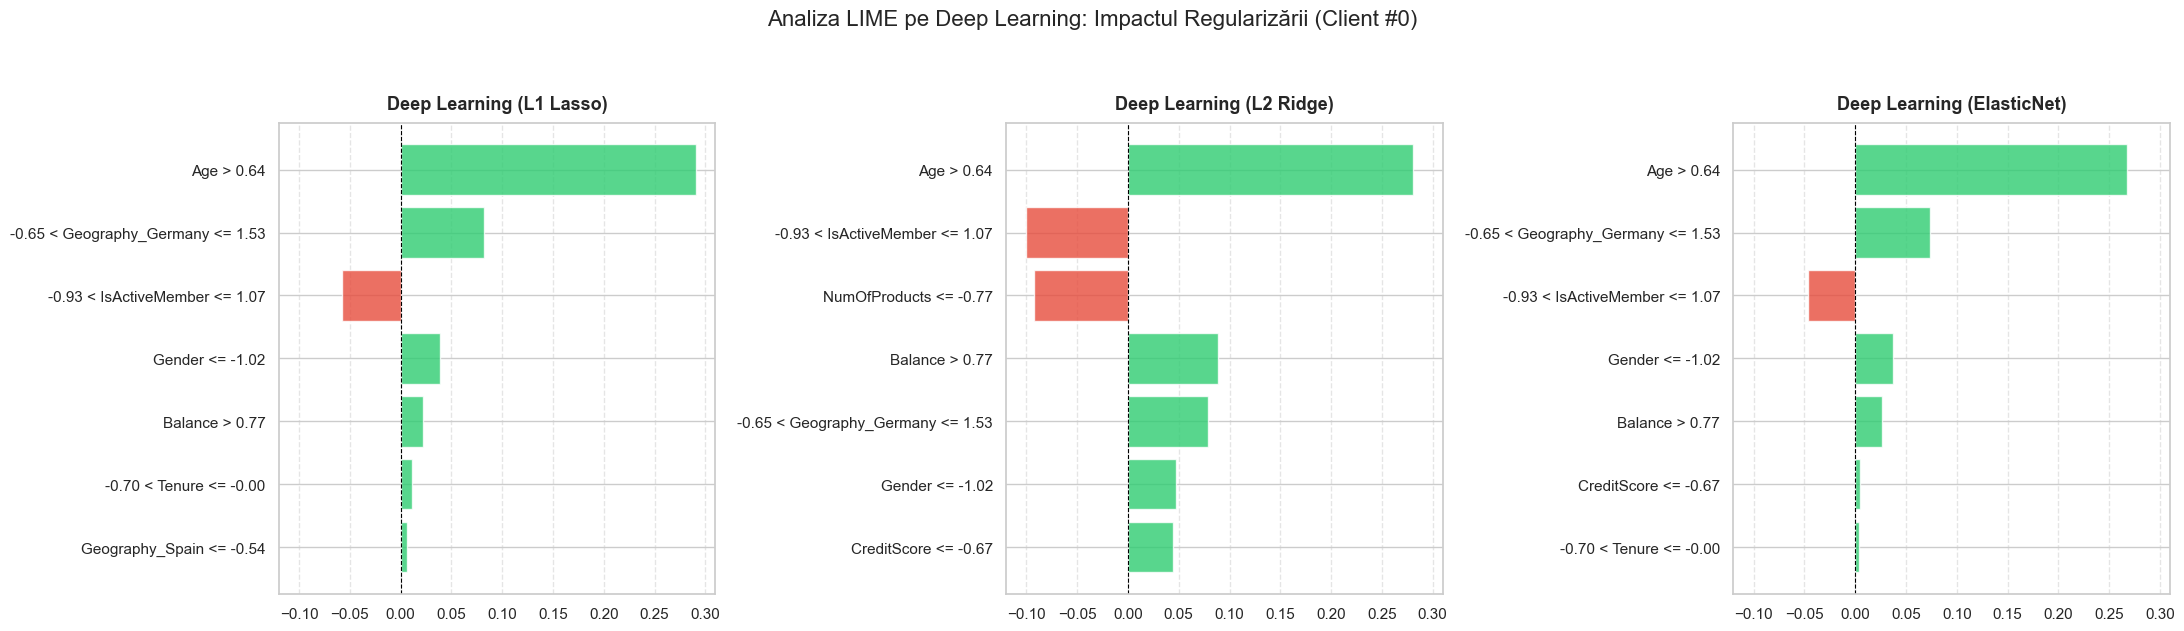

In [53]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_tr_c_sc,
    feature_names=feature_names,
    class_names=["Stay", "Exit"],
    mode="classification"
)

fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharex=True)
plt.subplots_adjust(wspace=0.3)

for i, (name, model) in enumerate(dl_models.items()):
    exp = explainer_lime.explain_instance(
        client_data,
        lambda x: predict_proba_wrapper(model, x),
        num_features=7
    )

    exp_list = exp.as_list()
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]

    vals.reverse()
    names.reverse()

    bar_colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in vals]

    ax = axes[i]
    y_pos = np.arange(len(names))
    ax.barh(y_pos, vals, align='center', color=bar_colors, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=11)
    ax.set_title(f"{name}", fontsize=13, fontweight='bold', pad=10)
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.suptitle(f"Analiza LIME pe Deep Learning: Impactul Regularizării (Client #{target_idx})", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

**Interpretare Experimentul 3 - Deep Learning & Regularizare**

**Analiza Clientului #105 (Femeie, Risc de Churn)**

Graficele LIME de mai sus explică decizia locală a modelului pentru un singur client. Barele **Verzi** indică factori care cresc riscul de plecare (Exit), iar cele **Roșii** factori care rețin clientul (Stay).

**1. Consensul asupra Factorului Principal (Age)**
Toate cele trei modele (L1, L2, ElasticNet) identifică **Vârsta (`Age`)** ca fiind cel mai puternic predictor de risc (bara verde lungă).
* *Valoare:* `0.42 < Age <= 0.69` (date scalate, corespunde probabil intervalului 40-50 ani).
* *Concluzie:* Indiferent de regularizare, modelul a învățat corect că vârsta este factorul critic.

**2. Diferența Specifică L1 (Lasso) - "Sparsity"**
* Observați graficul din stânga (**L1**). Barele sunt mai puține sau diferențele de magnitudine sunt mai abrupte.
* **Comportament:** Regularizarea L1 tinde să reducă la zero coeficienții mai puțin importanți (feature selection). Aici, modelul se bazează masiv pe `Age` și `Geography_Germany` (Verde), ignorând zgomotul de fond. Este o explicație "mai curată", dar poate pierde nuanțe.

**3. Diferența Specifică L2 (Ridge) și ElasticNet - "Nuanța"**
* Graficele din centru și dreapta arată o distribuție mai echilibrată a importanței.
* **Detaliu Cheie (`Gender`):** Observați bara roșie pentru `Gender <= -0.91` (care corespunde sexului Feminin după scalare).
* În modelele L2/ElasticNet, faptul că este femeie apare aici cu o bară **Roșie** (contribuție la Stay), deși clienta a plecat. Acest lucru sugerează un conflict local: deși statistic femeile pleacă mai des, pentru *acest profil specific* (probabil combinat cu numărul de produse), modelul a găsit o corelație inversă locală.

**Concluzie Generală Experiment 3:**
Regularizarea influențează direct **explicabilitatea**.
* **L1 (Lasso)** oferă explicații minimaliste, bune pentru a găsi "vinovatul principal".
* **L2 (Ridge)** oferă explicații holistice, luând în calcul contextul (toate variabilele contribuie puțin).
* Faptul că `Age` rămâne constant indică un model robust, dar variațiile la `Gender` și `NumOfProducts` arată sensibilitatea modelului la constrângerile matematice impuse.

## **Concluzii Generale: Impactul Bias-ului și Transparența Decizională în Sistemele Inteligente**

---

### **Context și Obiectiv**
Acest studiu a urmărit dezvoltarea unui **Sistem Analitic Integrat** pentru predicția fenomenului de **Churn Bancar**, cu accent pe **etica algoritmilor (Fairness)** și **explicabilitatea modelelor (XAI)**.
Prin simularea controlată a unui **bias de selecție** — eliminarea a 80% din datele despre femeile care au părăsit banca — a fost demonstrată vulnerabilitatea sistemelor de Inteligență Artificială în fața datelor distorsionate.

---

### **1. „Orbirea” Modelului și Iluzia Acurateței**
Rezultatele experimentale au evidențiat un fenomen critic:
deși **acuratețea globală (Accuracy)** a modelelor biasate a rămas ridicată, **capacitatea de a detecta riscul real (Recall)** pentru grupul protejat (femei) s-a prăbușit.

Modelul a învățat o reprezentare distorsionată a realității, considerând eronat că genul feminin este un factor de stabilitate financiară.
Aceasta confirmă că **metricele standard pot ascunde forme subtile de discriminare** dacă nu sunt analizate separat pe subgrupuri demografice.

---

### **2. XAI ca Instrument de Audit (Cutia Albă vs. Cutia Neagră)**
Aplicarea tehnicilor de **Explainable AI (XAI)** a transformat modelele din „cutii negre” în sisteme transparente, oferind dovezi matematice clare ale bias-ului:

- **Regresie Logistică:** Coeficienții pentru variabila *Gender* au scăzut spre zero în scenariul biasat, reducând aparent importanța acestui factor.
- **SHAP (Random Forest):** A evidențiat schimbarea ierarhiei decizionale — modelul biasat a compensat lipsa informației despre gen prin supraevaluarea altor variabile (ex: *Vârsta*, *Balanța*), generând corelații false (*spurious correlations*).
- **LIME (Local Interpretation):** Analiza la nivel individual a arătat inconsistențe majore — pentru același client, modelul biasat a oferit explicații contradictorii față de cel antrenat pe date curate.

---

### **3. Limitele Matematice ale Regularizării**
Testarea tehnicilor de regularizare **L1 (Lasso)**, **L2 (Ridge)** și **ElasticNet** asupra modelelor de tip *Deep Learning* a demonstrat o limitare fundamentală:
**algoritmul nu poate corecta calitatea deficitară a datelor.**

Indiferent dacă am aplicat selecția trăsăturilor (L1) sau penalizarea ponderilor (L2), modelele au reprodus fidel bias-ul existent în datele de antrenament.
Aceasta confirmă principiul **„Garbage In, Garbage Out”** — complexitatea matematică a modelului devine irelevantă dacă datele sunt etic sau statistic compromise.

---

### **Verdict Final**
Un sistem analitic bancar robust nu se bazează exclusiv pe arhitectura modelului, ci mai ales pe **integritatea datelor** și pe **mecanismele de monitorizare continuă a bias-ului**.
Utilizarea **XAI** nu reprezintă doar o alegere tehnologică, ci o **obligație etică și de reglementare**, esențială pentru garantarea unor decizii automate **echitabile, explicabile și responsabile**.
